In [6]:
import pandas as pd
import numpy as np
import numpy.random as nr
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [8]:
def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])
        
    return data

In [9]:
def fill_missing_values(df):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(df.columns)
    for _ in cols:

        df[_] = np.where(df[_] == np.inf, -999, df[_])
        df[_] = np.where(df[_] == np.nan, -999, df[_])
        df[_] = np.where(df[_] == -np.inf, -999, df[_])
        
    return df


In [13]:
PWD = '/media/Data-B/my_research/Geoscience_FL/data_well_log/'

A = np.load('penalty_matrix.npy')
train = pd.read_csv(PWD + 'train.csv', sep=';')
test = pd.read_csv(PWD + 'test.csv', sep=';')
hidden_test = pd.read_csv(PWD + 'hidden_test.csv', sep=';')

The augment_features_window function is used to concatenate feature windows in a given dataset. It takes two inputs: X, which is the input feature matrix, and N_neig, representing the number of neighboring windows to consider on each side of the current window. The function performs the following steps:

In [14]:
#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl


# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [15]:
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [17]:
class Model():

    '''
    class to lithology prediction
    '''
    
    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''
        
        self.train = train
        self.test = test

        
    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
        
        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values
        
        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values  
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''

        

        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = df.drop(cols, axis=1)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)
        
        df = df.fillna(-999)
        df = process(df)
        data = df.copy()
        
        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        
        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')
 
        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
        
        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')
    
        return traindata1, testdata1, lithology1, lithology_numbers

    
    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      open_test = np.zeros((len(testdata1), 12))
      
      #100 n-estimators and 10 max-depth
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
      
 
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]
    
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        open_test += model.predict_proba(pd.DataFrame(testdata1))
      
      open_test= pd.DataFrame(open_test/split)
    
      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')

                  
      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):

      '''
      method to train model, make prediction and create submission file
      args::
        filename: name to save submission file as (string)
      '''

      self.filename = filename

      prediction, model, lithology_numbers = self.fit(plot=False)
 
      path = PWD
    
      test = pd.read_csv(PWD + 'test.csv', sep=';')
      
      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:56:31] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16215
[99]	validation_0-mlogloss:0.31954
Default score: [-0.27864752]
Accuracy is: 0.894021460547449
F1 is: 0.8978208480954013
None
-----------------------FOLD 1---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:57:02] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16181
[99]	validation_0-mlogloss:0.31937
Default score: [-0.28026779]
Accuracy is: 0.8939351222971184
F1 is: 0.8978078023761155
None
-----------------------FOLD 2---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:57:33] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16213
[99]	validation_0-mlogloss:0.31527
Default score: [-0.2727529]
Accuracy is: 0.8962332658413854
F1 is: 0.9001243032802465
None
-----------------------FOLD 3---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:58:05] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16241
[99]	validation_0-mlogloss:0.31652
Default score: [-0.27515784]
Accuracy is: 0.8956779523455588
F1 is: 0.8996606094312234
None
-----------------------FOLD 4---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:58:36] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16193
[99]	validation_0-mlogloss:0.31757
Default score: [-0.27902261]
Accuracy is: 0.8939692954353231
F1 is: 0.8978878892874874
None
-----------------------FOLD 5---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:59:08] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16248
[99]	validation_0-mlogloss:0.32079
Default score: [-0.27906959]
Accuracy is: 0.8935335879232129
F1 is: 0.897526861939449
None
-----------------------FOLD 6---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:59:39] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16180
[99]	validation_0-mlogloss:0.31873
Default score: [-0.27675436]
Accuracy is: 0.8945331522157008
F1 is: 0.8985364631419458
None
-----------------------FOLD 7---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16175
[99]	validation_0-mlogloss:0.31729
Default score: [-0.27621186]
Accuracy is: 0.8951311821342833
F1 is: 0.8989913957394788
None
-----------------------FOLD 8---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:00:42] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16212
[99]	validation_0-mlogloss:0.32013
Default score: [-0.27950423]
Accuracy is: 0.89358484763052
F1 is: 0.8975053715831776
None
-----------------------FOLD 9---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:01:13] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16172
[99]	validation_0-mlogloss:0.31563
Default score: [-0.27536822]
Accuracy is: 0.8953703941017164
F1 is: 0.8991872356462184
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


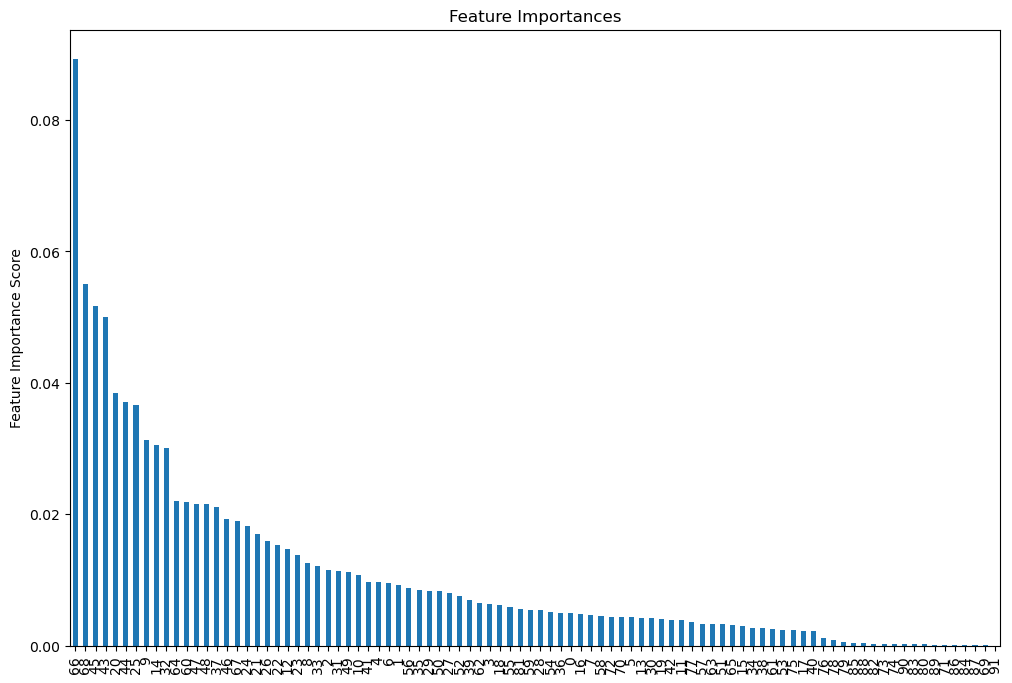

In [18]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

In [19]:
#using the make_submission_file method to make predicction and create a submission file

func_.make_submission_file(filename='pred_test')

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:03:52] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16206
[99]	validation_0-mlogloss:0.31844
Default score: [-0.27829512]
Accuracy is: 0.894209411201859
F1 is: 0.8981208679343147
None
-----------------------FOLD 1---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:04:23] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16230
[99]	validation_0-mlogloss:0.31880
Default score: [-0.27883572]
Accuracy is: 0.8939436655816695
F1 is: 0.8978072518291161
None
-----------------------FOLD 2---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:04:54] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16220
[99]	validation_0-mlogloss:0.31655
Default score: [-0.27522832]
Accuracy is: 0.895498543369984
F1 is: 0.8992098643650054
None
-----------------------FOLD 3---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16137
[99]	validation_0-mlogloss:0.31914
Default score: [-0.27716764]
Accuracy is: 0.8941657909800002
F1 is: 0.8982792966151355
None
-----------------------FOLD 4---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:05:56] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16190
[99]	validation_0-mlogloss:0.31849
Default score: [-0.27537996]
Accuracy is: 0.8951055522806298
F1 is: 0.8990513529437336
None
-----------------------FOLD 5---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:06:28] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16223
[99]	validation_0-mlogloss:0.32029
Default score: [-0.28067039]
Accuracy is: 0.8940376417117325
F1 is: 0.8980391947414109
None
-----------------------FOLD 6---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:06:58] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16199
[99]	validation_0-mlogloss:0.31684
Default score: [-0.27698824]
Accuracy is: 0.8949603164432598
F1 is: 0.8989692224061966
None
-----------------------FOLD 7---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:07:30] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16191
[99]	validation_0-mlogloss:0.31613
Default score: [-0.27358801]
Accuracy is: 0.8957292120528658
F1 is: 0.8995276459107066
None
-----------------------FOLD 8---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:08:02] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16267
[99]	validation_0-mlogloss:0.32042
Default score: [-0.28105484]
Accuracy is: 0.89314914011841
F1 is: 0.8969029545770902
None
-----------------------FOLD 9---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:08:34] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16150
[99]	validation_0-mlogloss:0.31721
Default score: [-0.27485882]
Accuracy is: 0.8954729135163305
F1 is: 0.8994028552127161
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


In [22]:
pred_df = pd.read_csv(f'{PWD}pred_test.csv')
pred_df['# lithology'].value_counts()

65000    96887
30000    23886
65030     9053
70000     5040
99000      990
80000      523
90000      392
86000       15
Name: # lithology, dtype: int64